# Predict Bike Trips

In this example, we build a machine learning application to predict the number of bike trips from a station in the next biking period. This application is structured into three important steps:

* Prediction Engineering
* Feature Engineering
* Machine Learning

In the first step, we generate new labels from the data by using [Compose](https://compose.alteryx.com/). In the second step, we generate features for the labels by using [Featuretools](https://docs.featuretools.com/). In the third step, we search for the best machine learning pipeline by using [EvalML](https://evalml.alteryx.com/). 
After working through these steps, you will learn how to build machine learning applications for real-world problems like forecasting demand. Let's get started.

In [1]:
from demo.chicago_bike import load_sample
from matplotlib.pyplot import subplots
import composeml as cp
import featuretools as ft
import evalml

2020-09-04 17:07:59,780 featuretools - WARNING    Featuretools failed to load plugin autonormalize from library autonormalize. For a full stack trace, set logging to debug.
2020-09-04 17:07:59,851 featuretools - WARNING    Featuretools failed to load plugin tsfresh from library featuretools_tsfresh_primitives.__init__. For a full stack trace, set logging to debug.
2020-09-04 17:07:59,919 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.


We will use data provided by [Divvy](https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data) which is a bicycle sharing system in Chicago. In this dataset, we have a record of each bike trip.

In [2]:
df = load_sample()
df.head()

,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,dpcapacity_start,to_station_id,dpcapacity_end
trip_id,,,,,,,,,,
2355134,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,10.066667,68.0,tstorms,131,15.0,303,15.0
2355133,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,4.383333,68.0,tstorms,282,15.0,22,15.0
2355130,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,2.100000,68.0,tstorms,327,19.0,225,15.0
2355129,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,58.016667,68.0,tstorms,134,19.0,194,11.0
2355128,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,10.633333,68.0,tstorms,320,15.0,134,19.0


## Prediction Engineering

> How many trips will occur from a station in the next biking period?

We can change the length of the biking period to create different prediction problems. For example, how many bike trips will occur in the next 13 hours or in the next week? These variations can be done by simply tweaking a parameter. This helps us explore different scenarios which is crucial for making better decisions.

### Defining the Labeling Function

Let's start by defining a labeling function to calculate the number of trips. Given that each observation is an individual trip, the number of trips is just the number of observations. Our labeling function will be used by a label maker to extract the training examples.

In [3]:
def trip_count(ds):
    return len(ds)

### Representing the Prediction Problem

Then, let's represent the prediction problem by creating a label maker with the following parameters:

* `target_entity` as the column for station ID where each trip starts from, since we want to process trips from each station.
* `labeling_function` as the function to calculate the number of trips.
* `time_index` as the column for the starting time of a trip. The biking periods are based on this time index.
* `window_size` as the length of a biking period. We can easily change this parameter to create variations of the prediction problem.

In [4]:
lm = cp.LabelMaker(
    target_entity='from_station_id',
    labeling_function=trip_count,
    time_index='starttime',
    window_size='13h',
)

### Finding the Training Examples

Now, let's run a search to get the training examples by using the following parameters:

* The trips sorted by the start time, since the search will expect the trips to be sorted chronologically, otherwise an error will be raised.
* `num_examples_per_instance` to find the number of training examples per station. In this case, the search will return all existing examples.
* `minimum_data` as the start time of the first biking period. This is also the first cutoff time for building features.

In [5]:
lt = lm.search(
    df.sort_values('starttime'),
    num_examples_per_instance=-1,
    minimum_data='2014-06-30 08:00',
    verbose=False,
)

lt.head()

,from_station_id,time,trip_count
0,5,2014-06-30 08:00:00,25
1,13,2014-06-30 08:00:00,22
2,14,2014-06-30 08:00:00,7
3,15,2014-06-30 08:00:00,7
4,16,2014-06-30 08:00:00,7


The output from the search is a label times table with three columns:

* The station ID associated to the trips. There can be many training examples generated from each station.
* The start time of the biking period. This is also the cutoff time for building features. Only data that existed beforehand is valid to use for predictions.
* The number of trips during the biking period window. This is calculated by our labeling function.

As a helpul reference, we can print out the search settings that were used to generate these labels.

In [6]:
lt.describe()

Settings
--------
gap                                      None
minimum_data                 2014-06-30 08:00
num_examples_per_instance                  -1
target_column                      trip_count
target_entity                 from_station_id
target_type                        continuous
window_size                               13h


Transforms
----------
No transforms applied



We can also get a better look at the labels by plotting the distribution and cumulative count across time.

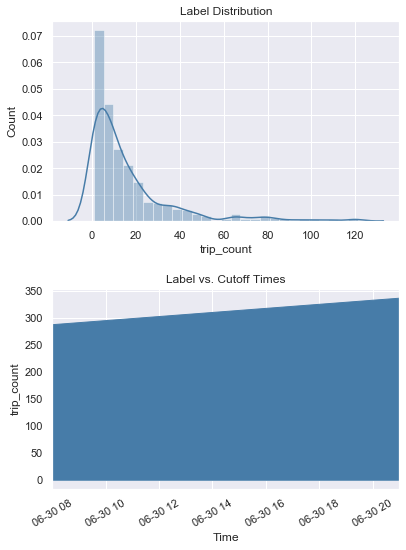

In [7]:
%matplotlib inline
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

## Feature Engineering

In the previous step, we generated the labels. The next step is to generate the features.

### Representing the Data

Let's start by representing the data with an entity set. This way, we can generate features based on the relational structure of the dataset. We currently have a single table of trips where one station can have many trips. This one-to-many relationship can be represented by normalizing a station entity. The same can be done with other one-to-many relationships like weather-to-trips. We want to make predictions based on the station where the trips started from, so we will use this station entity as the target entity for generating features. Also, we will use the stop times of the trips as the time index for generating features, since data about a trip would likely be unavailable until the trip is complete.

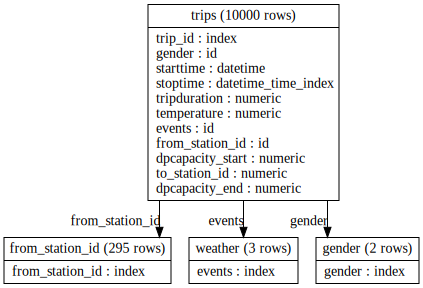

In [8]:
es = ft.EntitySet('chicago_bike')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='trips',
    time_index='stoptime',
    index='trip_id',
)

es.normalize_entity(
    base_entity_id='trips',
    new_entity_id='from_station_id',
    index='from_station_id',
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='trips',
    new_entity_id='weather',
    index='events',
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='trips',
    new_entity_id='gender',
    index='gender',
    make_time_index=False,
)

es["trips"]["gender"].interesting_values = ['Male', 'Female']
es["trips"]["events"].interesting_values = ['tstorms']
es.plot()

### Calculating the Features

Now, we can generate features by using a method called Deep Feature Synthesis (DFS). This will automatically build features by stacking and applying mathematical operations called primitives across relationships in an entity set. The more structured an entity set is, the better DFS can leverage the relationships to generate better features. Let’s run DFS using the following parameters:

* `entity_set` as the entity set we structured previously.
* `target_entity` as the station entity where the trips started from.
* `cutoff_time` as the label times that we generated previously. The label values are appended to the feature matrix.

In [9]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='from_station_id',
    trans_primitives=['hour', 'week', 'is_weekend'],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

,,SUM(trips.dpcapacity_end),SUM(trips.dpcapacity_start),SUM(trips.temperature),SUM(trips.to_station_id),SUM(trips.tripduration),STD(trips.dpcapacity_end),STD(trips.dpcapacity_start),STD(trips.temperature),STD(trips.to_station_id),STD(trips.tripduration),...,PERCENT_TRUE(trips.IS_WEEKEND(stoptime)),NUM_UNIQUE(trips.HOUR(starttime)),NUM_UNIQUE(trips.HOUR(stoptime)),NUM_UNIQUE(trips.WEEK(starttime)),NUM_UNIQUE(trips.WEEK(stoptime)),MODE(trips.HOUR(starttime)),MODE(trips.HOUR(stoptime)),MODE(trips.WEEK(starttime)),MODE(trips.WEEK(stoptime)),trip_count
from_station_id,time,,,,,,,,,,,,,,,,,,,,,
5,2014-06-30 08:00:00,430.0,342.0,1448.9,2714.0,185.016667,8.180960,0.0,4.450310,88.274675,6.381998,...,0.777778,10.0,9.0,2.0,2.0,7.0,14.0,26.0,26.0,25
13,2014-06-30 08:00:00,264.0,304.0,1318.1,3009.0,215.383333,2.000000,0.0,1.800081,88.920540,6.560637,...,1.000000,6.0,7.0,1.0,1.0,15.0,15.0,26.0,26.0,22
14,2014-06-30 08:00:00,38.0,30.0,157.9,399.0,56.866667,5.656854,0.0,8.414571,116.672619,34.035406,...,0.500000,2.0,2.0,2.0,2.0,7.0,7.0,26.0,26.0,7
15,2014-06-30 08:00:00,113.0,105.0,546.1,900.0,93.500000,3.023716,0.0,5.212942,83.755313,5.836839,...,0.571429,6.0,5.0,2.0,2.0,21.0,7.0,26.0,26.0,7
16,2014-06-30 08:00:00,246.0,154.0,1110.3,2281.0,220.483333,3.715131,0.0,5.738864,112.967296,9.146695,...,0.571429,6.0,6.0,2.0,2.0,7.0,7.0,26.0,26.0,7


There are two outputs from DFS: a feature matrix and feature definitions. The feature matrix is a table that contains the feature values with the corresponding labels based on the cutoff times. Feature definitions are features in a list that can be stored and reused later to calculate the same set of features on future data.

## Machine Learning

In the previous steps, we generated the labels and features. The final step is to build the machine learning pipeline.

### Splitting the Data

Let's start by extracting the labels from the feature matrix and splitting the data into a training set and holdout set.

In [10]:
y = fm.pop('trip_count')

splits = evalml.preprocessing.split_data(
    X=fm,
    y=y,
    test_size=0.1,
    random_state=0,
    regression=True,
)

X_train, X_holdout, y_train, y_holdout = splits

### Finding the Best Model

Then, let's run a search on the training set for the best machine learning model. During the search process, predictions from several different pipelines are evaluated to find the best pipeline.

In [11]:
automl = evalml.AutoMLSearch(
    problem_type='regression',
    objective='r2',
    random_state=0,
)

automl.search(
    X=X_train,
    y=y_train,
    data_checks='disabled',
    show_iteration_plot=False,
)

Using default limit of max_pipelines=5.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for R2. 
Greater score is better.

Searching up to 5 pipelines. 
Allowed model families: extra_trees, linear_model, random_forest, catboost, xgboost

(1/5) Mean Baseline Regression Pipeline        Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean R2: -0.016
(2/5) Extra Trees Regressor w/ Imputer + On... Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean R2: 0.415
(3/5) XGBoost Regressor w/ Imputer + One Ho... Elapsed:00:03
	Starting cross validation
	Finished cross validation - mean R2: 0.392
(4/5) CatBoost Regressor w/ Imputer            Elapsed:00:04
	Starting cross validation
	Finished cross validation - mean R2: 0.115
(5/5) Random Forest Regressor w/ Imputer + ... Elapsed:00:04
	Starting cross validation
	Finished cross validation - mean R2: 0.487

Search

Once the search is complete, we can print out information about the best pipeline found, such as the parameters in each component. 

********************************************************
* Random Forest Regressor w/ Imputer + One Hot Encoder *
********************************************************

Problem Type: Regression
Model Family: Random Forest

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * categories : None
	 * drop : None
	 * handle_unknown : ignore
	 * handle_missing : error
3. Random Forest Regressor
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1


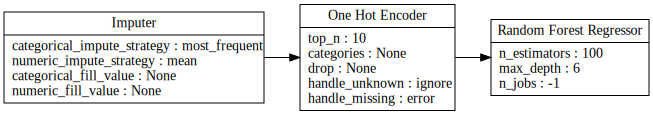

In [12]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

Let's score the model performance by evaluating predictions on the holdout set.

In [13]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['r2'],
)

dict(score)

{'R2': 0.5926794130478419}

From the pipeline, we can see which features are most important for predictions.

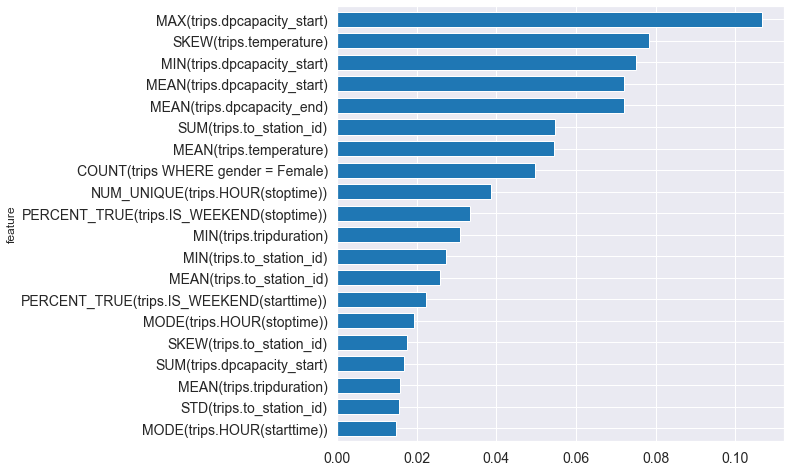

In [14]:
feature_importance = best_pipeline.feature_importance
feature_importance = feature_importance.set_index('feature')['importance']
top_k = feature_importance.abs().sort_values().tail(20).index
feature_importance[top_k].plot.barh(figsize=(8, 8), fontsize=14, width=.7);

### Making Predictions

We are ready to make predictions with our trained model. First, let's calculate the same set of features by using the feature definitions. We will use a cutoff time based on the latest information available in the dataset.

In [15]:
fm = ft.calculate_feature_matrix(
    features=fd,
    entityset=es,
    cutoff_time=ft.pd.Timestamp('2014-07-02 08:00:00'),
    cutoff_time_in_index=True,
    verbose=False,
)

fm.head()

,,SUM(trips.dpcapacity_end),SUM(trips.dpcapacity_start),SUM(trips.temperature),SUM(trips.to_station_id),SUM(trips.tripduration),STD(trips.dpcapacity_end),STD(trips.dpcapacity_start),STD(trips.temperature),STD(trips.to_station_id),STD(trips.tripduration),...,PERCENT_TRUE(trips.IS_WEEKEND(starttime)),PERCENT_TRUE(trips.IS_WEEKEND(stoptime)),NUM_UNIQUE(trips.HOUR(starttime)),NUM_UNIQUE(trips.HOUR(stoptime)),NUM_UNIQUE(trips.WEEK(starttime)),NUM_UNIQUE(trips.WEEK(stoptime)),MODE(trips.HOUR(starttime)),MODE(trips.HOUR(stoptime)),MODE(trips.WEEK(starttime)),MODE(trips.WEEK(stoptime))
from_station_id,time,,,,,,,,,,,,,,,,,,,,,
240,2014-07-02 08:00:00,731.0,1035.0,3669.3,10607,429.250000,3.053728,0.0,3.747205,67.386478,8.421625,...,0.400000,0.400000,14,14,2,2,17,17,27,27
181,2014-07-02 08:00:00,1598.0,2294.0,6131.8,10215,813.700000,5.974647,0.0,3.203923,84.246286,6.410074,...,0.310811,0.310811,15,15,2,2,16,16,27,27
186,2014-07-02 08:00:00,414.0,330.0,1750.9,3820,239.083333,4.696872,0.0,4.486731,105.205262,5.831690,...,0.272727,0.272727,11,10,2,2,8,9,27,27
177,2014-07-02 08:00:00,2960.0,2280.0,12632.5,29497,2802.416667,7.335794,0.0,2.554102,99.069461,7.980209,...,0.703947,0.703947,13,14,2,2,16,16,26,26
219,2014-07-02 08:00:00,608.0,396.0,2920.4,5633,388.766667,3.762809,0.0,4.040022,110.994333,6.417246,...,0.555556,0.555556,15,14,2,2,17,8,26,26


Now, let's predict the number of trips that will occur from a station in the next 13 hours.

In [16]:
values = best_pipeline.predict(fm).values.round()

prediction = fm[[]]
prediction['trip_count (estimate)'] = values
prediction.head()

,,trip_count (estimate)
from_station_id,time,
240,2014-07-02 08:00:00,5.0
181,2014-07-02 08:00:00,2.0
186,2014-07-02 08:00:00,7.0
177,2014-07-02 08:00:00,10.0
219,2014-07-02 08:00:00,4.0


### Next Steps

At this point, we have completed the machine learning application. We can revisit each step to explore and fine-tune with different parameters until the model is ready for deployment. For more information on how to work with the features produced by Featuretools, take a look at [the Featuretools documentation](https://docs.featuretools.com/). For more information on how to work with the models produced by EvalML, take a look at [the EvalML documentation](https://evalml.alteryx.com/).